In [1]:
import os
import sys
import logging

sys.path.append(
    "/usr/lib/spark/python"
)

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
import pyspark.sql.functions as f
import re
from pyspark.sql.functions import col, asc, desc, isnan, when, trim

from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import FloatType, DoubleType, IntegerType, StringType, TimestampType

from pyspark.sql.functions import udf
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.pipeline import Pipeline

import mlflow
from mlflow.tracking import MlflowClient
from datetime import datetime

from scipy.stats  import norm, ttest_ind
from scipy import stats
import numpy as np

from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
spark = (
    SparkSession.builder.appName('validate')
    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.3.4')
    .config("spark.executor.memory", "128g")
    .config("spark.driver.memory", "128g")
    .config("spark.executor.cores", "40")
    .config("spark.executor.instances", "48")
    .config("spark.default.parallelism", "48")
    .getOrCreate()
)
hadoop_conf = spark.sparkContext._jsc.hadoopConfiguration()
hadoop_conf.set("fs.s3.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
hadoop_conf.set("fs.s3a.access.key", "key")
hadoop_conf.set("fs.s3a.secret.key", "secret")
hadoop_conf.set("fs.s3a.endpoint", "storage.yandexcloud.net")
hadoop_conf.set('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.3.4')

In [3]:
def evaluateModel(predictions):
    predictionAndTarget = predictions.select([predictions["tx_fraud"].cast(DoubleType()), predictions["prediction"].cast(DoubleType()).alias('label')])
    metrics_binary = BinaryClassificationMetrics(predictionAndTarget.rdd.map(tuple))
    metrics_multi = MulticlassMetrics(predictionAndTarget.rdd.map(tuple))
    return {'acc': metrics_multi.accuracy,
            'f1': metrics_multi.fMeasure(1.0),
            'precision': metrics_multi.precision(1.0),
            'recall': metrics_multi.recall(1.0),
            'auc': metrics_binary.areaUnderROC,
            'arp': metrics_binary.areaUnderPR
           }

In [4]:
def getScores(predictions):
    bootstrap_iterations = 100
    predictionAndTarget = predictions.select([predictions["tx_fraud"].cast(DoubleType()), predictions["prediction"].cast(DoubleType()).alias('label')])
    scores = []
    for i in range(bootstrap_iterations):
        sample = predictionAndTarget.sample(True, 0.01)
        metrics_binary = BinaryClassificationMetrics(sample.rdd.map(tuple))
        scores.append(metrics_binary.areaUnderPR)
    return scores

In [5]:
def makeFig(scores, scores_candidate):
    # Create a figure and axis for the plot
    fig, axes = plt.subplots(1, 1, figsize=(8, 5))
    
    # Plot histograms for each dataset
    sns.histplot(data=pd.DataFrame(scores, columns=['APR']), x="APR", ax=axes, color='blue', label=calc_confidence_interval(scores), alpha=0.3)
    sns.histplot(data=pd.DataFrame(scores_candidate, columns=['APR']), x="APR", ax=axes, color='orange', label=calc_confidence_interval(scores_candidate), alpha=0.3)
    
    # Set plot labels and titles
    axes.set_xlabel("Area under Precision-Recall")
    axes.set_ylabel('Count')
    axes.set_title(f'{"Area under Precision-Recall"}')
    
    # Add legend
    axes.legend()
    
    # Adjust the layout
    plt.tight_layout()
    
    # Show the plot
    plt.savefig("plots/apr.png")
    return fig

In [6]:
def isValid(scores, scores_candidate, alpha = 0.01):
    pvalue = ttest_ind(scores, scores_candidate).pvalue
    
    print(f"p-value (APR): {pvalue:g}\t-\t", end='')
    if pvalue < alpha:
        print("Reject null hypothesis.")
    else:
        print("Accept null hypothesis.")
    return pvalue < alpha

In [7]:
def calc_confidence_interval(scores):
    scores_arr = np.asarray(scores)
    mean = scores_arr.mean()
    std_error = scores_arr.std() / np.sqrt(len(scores_arr))
    confidence_level = 0.95
    
    confidence_interval = stats.t.interval(confidence_level, len(scores)-1, mean, std_error)
    return (f'Confidence interval for APR: {confidence_interval[0]:.4f} <- {scores_arr.mean():.4f} -> {confidence_interval[1]:.4f}')

In [10]:
df = spark.read.parquet("s3a://mlops-homework-rvsmsjima/dataset-cleaned.parquet")

In [ ]:
%%time
# возьмем только 1% данных для сокращения времени отладки и обучения
#subsets = df.randomSplit([0.5, 0.95])
subset = df.sample(0.01)

df_1 = subset.filter(subset["tx_fraud"] == 1)
df_0 = subset.filter(subset["tx_fraud"] == 0)

df_1count = df_1.count()
df_0count = df_0.count()

df1_oversampled = df_1 \
.withColumn("dummy",
        f.explode(
            f.array(*[f.lit(x)
                      for x in range(int(df_0count / df_1count))]))) \
.drop("dummy")

data = df_0.unionAll(df1_oversampled)

data_indexer = StringIndexer(inputCols=["tx_fraud_scenario"], outputCols=["tx_fraud_scenario_index"])
data_encoder = OneHotEncoder(inputCols=["tx_fraud_scenario_index"], outputCols=["tx_fraud_scenario_encoded"])

numeric_cols = ["tx_amount", "tx_time_seconds", "tx_time_days"]
cat_cols = ["tx_fraud_scenario_encoded"]
featureColumns = numeric_cols + cat_cols

assembler = VectorAssembler() \
.setInputCols(featureColumns) \
.setOutputCol("features") \
.setHandleInvalid("skip")

scaler = MinMaxScaler() \
.setInputCol("features") \
.setOutputCol("scaledFeatures")

scaled = Pipeline(stages=[data_indexer,
                          data_encoder,
                          assembler,
                          scaler,
                         ]).fit(data).transform(data)

tt = scaled.randomSplit([0.8, 0.2])
training = tt[0]
test = tt[1]

In [ ]:
training.write.parquet("s3a://mlops-homework-rvsmsjima/training.parquet", mode="overwrite")
test.write.parquet("s3a://mlops-homework-rvsmsjima/test.parquet", mode="overwrite")

In [9]:
%%time
training = spark.read.parquet("s3a://mlops-homework-rvsmsjima/training.parquet").cache()
test = spark.read.parquet("s3a://mlops-homework-rvsmsjima/test.parquet").cache()

CPU times: user 1.13 ms, sys: 4.36 ms, total: 5.49 ms
Wall time: 945 ms


24/06/23 20:56:15 WARN CacheManager: Asked to cache already cached data.


In [10]:
os.environ["AWS_ACCESS_KEY_ID"] = "key"
os.environ["AWS_SECRET_ACCESS_KEY"] = "secret"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_DEFAULT_REGION"] = "ru-central1"

mlflow.set_tracking_uri("http://mlflow.fraudnames.ru:5000")

In [11]:
experiment = mlflow.set_experiment("baseline")
experiment_id = experiment.experiment_id

run_name = 'baseline model for data subset ' + str(datetime.now())

In [13]:
%%time
# baseline model
with mlflow.start_run(run_name=run_name, experiment_id=experiment_id):
    setRegParam = 0.2
    setElasticNetParam = 0.8
    
    lr = (
    LogisticRegression()
        .setMaxIter(1)
        .setRegParam(setRegParam)
        .setElasticNetParam(setElasticNetParam)
        .setFamily("binomial")
        .setFeaturesCol("scaledFeatures")
        .setLabelCol("tx_fraud")
    )
    lrModel = lr.fit(training)
    baseline_run_id = mlflow.active_run().info.run_id
    mlflow.log_param('optimal_regParam', setRegParam)
    mlflow.log_param('optimal_elasticNetParam', setElasticNetParam)
    trainingSummary = lrModel.summary
    accuracy_trainingSummary = trainingSummary.accuracy
    areaUnderROC_trainingSummary = trainingSummary.areaUnderROC
    mlflow.log_metric("accuracy_trainingSummary", accuracy_trainingSummary)
    mlflow.log_metric("areaUnderROC_trainingSummary", areaUnderROC_trainingSummary)
    predictions_baseline = lrModel.transform(test)
    metrics_baseline = evaluateModel(predictions_baseline)
    for metric in metrics_baseline.keys():
        mlflow.log_metric(metric, metrics_baseline[metric])
    
    mlflow.spark.log_model(lrModel, "lrModel")
mlflow.end_run()

24/06/23 21:02:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
/home/apopov/.local/pipx/venvs/jupyterlab/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
2024/06/23 21:06:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp89x86mzf, flavor: spark). Fall back to return ['pyspark==3.5.1']. Set logging level to DEBUG to see the full traceback. 
/home/apopov/.local/pipx/shared/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or

CPU times: user 2.89 s, sys: 327 ms, total: 3.22 s
Wall time: 8min 49s


In [25]:
experiment = mlflow.set_experiment("staging")
experiment_id = experiment.experiment_id
run_name = 'staging model for data subset ' + str(datetime.now())

/home/apopov/.local/pipx/venvs/jupyterlab/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
2024/06/23 21:23:44 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp2nlkn4a9, flavor: spark). Fall back to return ['pyspark==3.5.1']. Set logging level to DEBUG to see the full traceback. 


p-value (APR): 5.33119e-231	-	Reject null hypothesis.
CPU times: user 3.27 s, sys: 1.15 s, total: 4.42 s
Wall time: 5min 8s


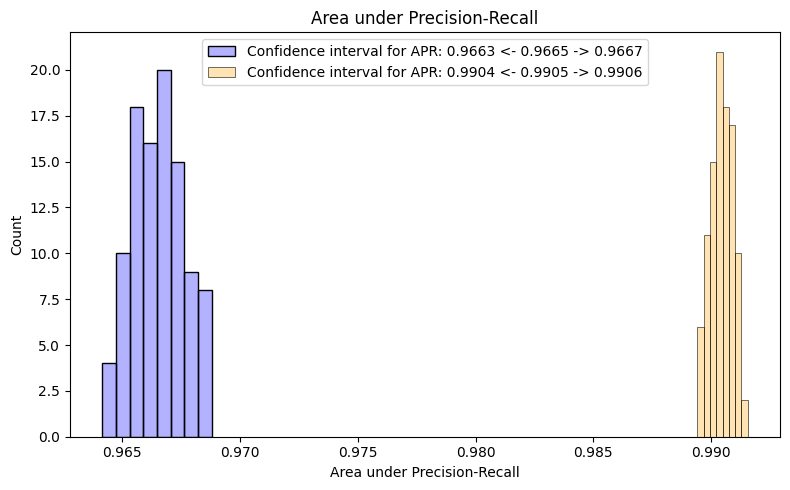

In [26]:
%%time
# staging model
with mlflow.start_run(run_name=run_name, experiment_id=experiment_id):
    staging_run_id = mlflow.active_run().info.run_id
    evaluator = BinaryClassificationEvaluator(labelCol="tx_fraud", metricName="areaUnderPR")
    grid = (
    ParamGridBuilder()
        .addGrid(lr.regParam, [0.05, 0.1, 0.5])
        .addGrid(lr.fitIntercept, [False, True])
        .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
        .build()
    )

    tvs = (
    TrainValidationSplit()
        .setEstimator(lr)
        .setEvaluator(evaluator)
        .setEstimatorParamMaps(grid)
        .setCollectSubModels(True)
        .setParallelism(2)
    )
    
    tvsModel = tvs.fit(training)
    param_map = tvsModel.bestModel.extractParamMap()
    for param in param_map:
        mlflow.log_param(param.name, param_map[param])
    
    predictions_staging = tvsModel.transform(test)
    metrics_staging = evaluateModel(predictions_staging)
    for metric in metrics_staging.keys():
        mlflow.log_metric(metric, metrics_staging[metric])

    mlflow.spark.log_model(tvsModel, "tvsModel")

    scores = getScores(predictions_baseline)
    scores_candidate = getScores(predictions_staging)

    mlflow.log_figure(makeFig(scores, scores_candidate), "/tmp/apr.png")
    mlflow.log_metric("isValid", isValid(scores, scores_candidate))

In [27]:
if (isValid(scores, scores_candidate)):
    result = mlflow.register_model('runs:/'+staging_run_id+'/tvsModel', "bestModel")
    print(result)

p-value (APR): 5.33119e-231	-	Reject null hypothesis.


Successfully registered model 'bestModel'.
2024/06/23 21:34:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: bestModel, version 1


<ModelVersion: aliases=[], creation_timestamp=1719167685481, current_stage='None', description='', last_updated_timestamp=1719167685481, name='bestModel', run_id='f2c798cadee743d69de14150ea8b2204', run_link='', source='s3://mlops-mlflow-artifacts/2/f2c798cadee743d69de14150ea8b2204/artifacts/tvsModel', status='READY', status_message='', tags={}, user_id='', version='1'>


Created version '1' of model 'bestModel'.


In [29]:
client = MlflowClient()
client.transition_model_version_stage(
    name="bestModel", version=result.version, stage="Production"
)

/tmp/ipykernel_2180864/2499481128.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1719167685481, current_stage='Production', description='', last_updated_timestamp=1719167951802, name='bestModel', run_id='f2c798cadee743d69de14150ea8b2204', run_link='', source='s3://mlops-mlflow-artifacts/2/f2c798cadee743d69de14150ea8b2204/artifacts/tvsModel', status='READY', status_message='', tags={}, user_id='', version='1'>

In [9]:
spark.stop()